**Importing Libraries and Dataset**

In [104]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import joblib


df = pd.read_csv("./model_dataset/vehicles_merged.csv")


**Recommendation Model K-NN**


In [ ]:
body_types = [
    "sedan","hatchback","suv","mpv","pickup","coupe",
    "convertible","wagon","van","crossover","kei / microvan",
    "roadster","other","liftback","mpv / minivan","minivan","microvan"
    ,"kei"
]
road_cols = ['City/Urban', "Suburban/Normal", "Mid Off-Road", "Off-Road/Hilly Terrain"]
fuel_types = df['Fuel Type'].str.lower().unique().tolist()


for bt in body_types:
    df[f'Body_{bt}'] = df['Body Type'].apply(
        lambda x: 1 if bt.lower() in [t.strip().lower() for t in str(x).replace('/', ',').split(',')] else 0
    )

for f in fuel_types:
    df[f'Fuel_{f}'] = df['Fuel Type'].str.lower().apply(lambda x: 1 if x == f else 0)

feature_cols = (
    [f'Body_{bt}' for bt in body_types] +
    ['Seating Capacity'] +
    road_cols +
    ['Eff (km/l)', 'Ground Clearance (range)'] +
    [f'Fuel_{f}' for f in fuel_types]
)


road_mapping = {
    "town": "City/Urban",
    "urban": "City/Urban",
    "city": "City/Urban",
    "suburban": "Suburban/Normal",
    "mid off-road": "Mid Off-Road",
    "off-road": "Off-Road/Hilly Terrain",
    "hilly": "Off-Road/Hilly Terrain"
}

#User Input
user_body = input("Enter body type(s), comma separated: ")
user_seating = input("Enter seating capacity(s), comma separated (e.g., 4,5,7): ")
user_road = input("Enter road types, comma separated: ")
user_traffic = input("Enter traffic condition(s) , comma separated (high/mid/low/mixed): ")
user_fuel = input("Enter fuel type(s), comma separated: ")

user_body_list = [b.strip().lower() for b in user_body.split(',')]
user_road_list = [r.strip().lower() for r in user_road.split(',')]
user_fuel_list = [f.strip().lower() for f in user_fuel.split(',')]
user_traffic_list = [t.strip().lower() for t in user_traffic.split(',')]
user_seating_list = [int(s.strip()) for s in user_seating.split(',') if s.strip().isdigit()]

#Fuel prioraty by traffic condition
if "high" in user_traffic_list:
    preferred_fuels = ["electric","hybrid", "petrol", "diesel"] #High traffic means more stop and go, so electric and hybrid are prioritized
elif "mixed" in user_traffic_list:
    preferred_fuels = ["hybrid", "petrol", "electric", "diesel"] #Mixed traffic means a balance between stop and go and steady driving
elif "mid" in user_traffic_list:
    preferred_fuels = ["hybrid", "petrol", "diesel","electric"] #Mid traffic means more steady driving, so hybrid and petrol are prioritized
else:  # low traffic
    preferred_fuels = ["petrol", "diesel", "hybrid","electric"]

user_fuel_list = list(dict.fromkeys(preferred_fuels + user_fuel_list))

#Dataset filtering based on user input
filtered_df = df[df['Fuel Type'].str.lower().isin(user_fuel_list)].copy()

filtered_df = filtered_df[
    filtered_df[[f'Body_{bt}' for bt in body_types]].apply(
        lambda row: any(row[f'Body_{bt}'] == 1 for bt in user_body_list if f'Body_{bt}' in row.index),
        axis=1
    )
]

# Filter by seating capacity 
exact_match_df = filtered_df[filtered_df['Seating Capacity'].isin(user_seating_list)]

# If no exact matches, show vehicles with ±1 seat of any given value
if exact_match_df.empty:
    print(f"No exact seat matches found for {user_seating_list}. Showing nearby options.")
    filtered_df = filtered_df[
        filtered_df['Seating Capacity'].apply(
            lambda x: any(abs(x - s) <= 1 for s in user_seating_list)
        )
    ]
else:
    filtered_df = exact_match_df


if filtered_df.empty:
    print("No vehicles match your selected body type and fuel type.")
else:
    X_filtered = filtered_df[feature_cols].fillna(0)

    # User input as feature vector
    user_seating = user_seating_list[0] if user_seating_list else df['Seating Capacity'].mode()[0]
    body_vec = [1 if bt in user_body_list else 0 for bt in body_types]
    road_vec = [1 if rc in [road_mapping.get(r, "") for r in user_road_list] else 0 for rc in road_cols]

    # Fuel efficiency adjustment based on traffic
    if "high" in user_traffic_list:
        fuel_efficiency = df['Eff (km/l)'].max() * 0.95
    elif "mixed" in user_traffic_list:
        fuel_efficiency = df['Eff (km/l)'].mean() * 1.05
    elif "mid" in user_traffic_list:
        fuel_efficiency = df['Eff (km/l)'].mean()
    else:  # low
        fuel_efficiency = df['Eff (km/l)'].mean() * 0.85

    # Ground clearance preference
    if any(r in ["off-road", "mid off-road", "hilly"] for r in user_road_list):
        ground_clearance = df['Ground Clearance (range)'].max()
    else:
        ground_clearance = df['Ground Clearance (range)'].mean()

    fuel_vec = [1 if f in user_fuel_list else 0 for f in fuel_types]

    user_vector = body_vec + [user_seating] + road_vec + [fuel_efficiency, ground_clearance] + fuel_vec

#--------------------Feature Scaling-------------------#

    numeric_cols = ['Seating Capacity', 'Eff (km/l)', 'Ground Clearance (range)']
    scaler = StandardScaler()

    # Scale numeric columns
    X_filtered_scaled = X_filtered.copy()
    X_filtered_scaled[numeric_cols] = scaler.fit_transform(X_filtered[numeric_cols])

    # Scale user numeric inputs
    numeric_values_scaled = scaler.transform([[user_seating, fuel_efficiency, ground_clearance]])[0]

    # Replace numeric values in user vector with scaled ones
    user_vector_scaled = user_vector.copy()
    start_idx = len(body_types)
    eff_idx = start_idx + 1 + len(road_cols)
    gc_idx = eff_idx + 1
    user_vector_scaled[start_idx] = numeric_values_scaled[0]
    user_vector_scaled[eff_idx] = numeric_values_scaled[1]
    user_vector_scaled[gc_idx] = numeric_values_scaled[2]

#--------------------KNN Model and Recommendations-------------------#

    knn = NearestNeighbors(n_neighbors=len(X_filtered), metric='euclidean')
    knn.fit(X_filtered_scaled)

    distances, indices = knn.kneighbors([user_vector_scaled])
    recommended_all = filtered_df.iloc[indices[0]].copy()
    recommended_all['Distance'] = distances[0]

    # Sort by fuel priority then distance and seating priority
    recommended_all['Seat_Priority'] = recommended_all['Seating Capacity'].apply(
        lambda s: 0 if s in user_seating_list else 1
    )

    recommended_all['Fuel_Priority'] = recommended_all['Fuel Type'].str.lower().apply(
        lambda f: preferred_fuels.index(f) if f in preferred_fuels else len(preferred_fuels)
    )
    recommended_all.sort_values(by=['Seat_Priority','Fuel_Priority', 'Distance'], inplace=True)


#-------------------Display recommendations-------------------#

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)
    pd.set_option('display.max_colwidth', None)

    print("\nRecommended Vehicles Ranked by Similarity and Fuel Priority:\n")
    print(recommended_all[['Manufacturer', 'Model', 'Body Type', 'Seating Capacity', 'Fuel Type', 'Eff (km/l)', 'Ground Clearance (range)']])



Recommended Vehicles Ranked by Similarity and Fuel Priority:

       Manufacturer              Model               Body Type  Seating Capacity Fuel Type  Eff (km/l)  Ground Clearance (range)
1074         Toyota      prius g sport                liftback                 5    Hybrid         NaN                       142
1075         Toyota            prius s                liftback                 5    Hybrid         NaN                       142
1082         Toyota        prius zvw50                liftback                 5    Hybrid         NaN                       142
1073         Toyota              prius                liftback                 5    Hybrid         NaN                       142
1081         Toyota      prius z grade                liftback                 5    Hybrid         NaN                       142
1078         Toyota            prius u                liftback                 5    Hybrid         NaN                       142
1080         Toyota            pri

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


**Visualization**


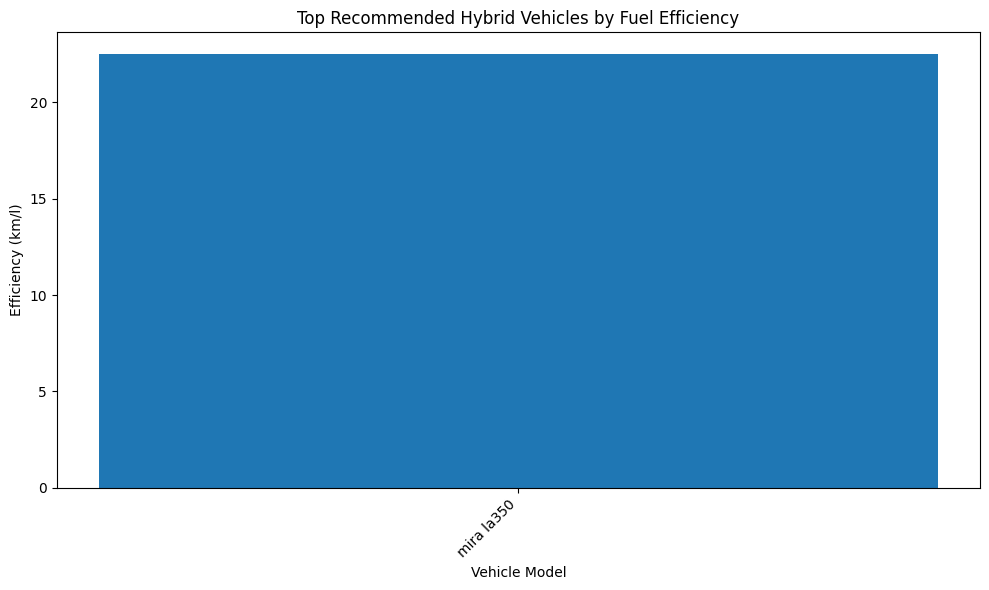

No vehicles found for Electric in top recommendations.
No vehicles found for Petrol in top recommendations.
No vehicles found for Diesel in top recommendations.


In [107]:
top_n = recommended_all.head(10)
fuel_categories = ['hybrid', 'electric', 'petrol', 'diesel']

for fuel in fuel_categories:
    fuel_df = top_n[top_n['Fuel Type'].str.lower() == fuel]

    if not fuel_df.empty:
        plt.figure(figsize=(10, 6))
        plt.bar(fuel_df['Model'], fuel_df['Eff (km/l)'])
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Top Recommended {fuel.capitalize()} Vehicles by Fuel Efficiency")
        plt.xlabel("Vehicle Model")
        plt.ylabel("Efficiency (km/l)")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No vehicles found for {fuel.capitalize()} in top recommendations.")

**Piplining - New Vehicle Data**

In [101]:

df = df.loc[:, ~df.columns.duplicated()]

def compute_average(fuel_eff):
    try:
        fuel_eff = str(fuel_eff).strip()
        if '-' in fuel_eff:
            parts = [float(x) for x in fuel_eff.split('-')]
            return sum(parts) / len(parts)
        else:
            return float(fuel_eff)
    except:
        return 0
# ---------------------------
# Detect numeric body type columns dynamically


body_cols = [col for col in df.columns if col.lower().startswith("body type") and df[col].dtype in [int, float]]

# Road and numeric features
road_cols = ['City/Urban', "Suburban/Normal", "Mid Off-Road", "Off-Road/Hilly Terrain"]
numeric_features = ['Seating Capacity', 'Eff (km/l)', 'Ground Clearance (range)'] + road_cols

# Feature columns for KNN (numeric only)
feature_cols = numeric_features + body_cols

# ---------------------------
# ColumnTransformer
# ---------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('body', 'passthrough', body_cols)
    ]
)

# ---------------------------
# KNN Pipeline
# ---------------------------
knn_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('knn', NearestNeighbors(n_neighbors=len(df), metric='euclidean'))
])

# Fill missing values with 0
X = df[feature_cols].fillna(0)

# Fit pipeline
knn_pipeline.fit(X)



# ---------------------------
# Function to add new vehicles
# ---------------------------
def add_new_vehicles(new_vehicles_df, csv_file="./model_dataset/vehicles_merged.csv"):
    global df, knn_pipeline, feature_cols, body_cols, numeric_features

    # If new vehicles have textual "Body Type", convert to one-hot
    if 'Body Type' in new_vehicles_df.columns:
        for col in body_cols:
            # Extract type name from column (e.g., 'Body Type 3 (suv)' -> 'suv')
            type_name = col.split('(')[-1].replace(')','').strip().lower()
            new_vehicles_df[col] = new_vehicles_df['Body Type'].str.lower().apply(lambda x: 1 if x == type_name else 0)
        new_vehicles_df = new_vehicles_df.drop(columns=['Body Type'])

    # Ensure all numeric/body columns exist in the new data
    for col in feature_cols:
        if col not in new_vehicles_df.columns:
            new_vehicles_df[col] = 0

    # Append new vehicles
    df = pd.concat([df, new_vehicles_df], ignore_index=True)

    # Remove any duplicate columns again
    df = df.loc[:, ~df.columns.duplicated()]

    # ---------------------------
    df['Eff (km/l)'] = df['Fuel Efficiency'].apply(compute_average)

    # Sort alphabetically by Manufacturer and Model
    if 'Manufacturer' in df.columns and 'Model' in df.columns:
        df = df.sort_values(by=['Manufacturer', 'Model']).reset_index(drop=True)

    # Refit pipeline
    X = df[feature_cols].fillna(0)
    knn_pipeline.fit(X)

    # Save updated CSV
    df.to_csv(csv_file, index=False)
    print(f"Added {len(new_vehicles_df)} new vehicles and saved to {csv_file}")


# ---------------------------
# Example: Add a new vehicle
# ---------------------------
new_vehicles = pd.DataFrame([{
    "Manufacturer": "BYD",
    "Model": "Sealion 5",
    "Fuel Type": "Electric",
    "Fuel Efficiency": "4.5",
    "Eff (km/l)": 0,
    "Body Type": "suv",
    "Seating Capacity": 5,
    "Ground Clearance (range)": 170,
    "City/Urban": 1,
    "Suburban/Normal": 1,
    "Mid Off-Road": 0,
    "Off-Road/Hilly Terrain": 0,
    "Year": 2025
}])

# Add new vehicle
add_new_vehicles(new_vehicles)


Added 1 new vehicles and saved to ./model_dataset/vehicles_merged.csv
